In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import spacy

In [3]:
base_dir = os.getcwd()
output_dir1 = os.path.join(base_dir, "..", "..", "output")
output_dir2 = os.path.join(base_dir, "..", "..", "data")

file_path1 = os.path.join(output_dir1, "fake_news_flag.csv")
df1 = pd.read_csv(file_path1)

file_path2 = os.path.join(output_dir1, "redirected_urls_1.csv")
df2 = pd.read_csv(file_path2)

file_path3 = os.path.join(output_dir2, "train.txt")
df3 = pd.read_csv(file_path3, sep='\t')

In [3]:
df3.columns = ["Unique_ID", "Text", "Fake_News_Flag"]

In [4]:
df1 = pd.merge(df1, df2[['Message_ID', 'Cleaned_text']], on='Message_ID', how='left')

In [5]:
# Generic function to perform the analysis
def analyze_datasets(df1, df3, label1, label2, text_column_1="Cleaned_text", text_column_3="Text", nlp_model="en_core_web_sm"):
    # Step 1: Message Length Distribution
    df1["length"] = df1[text_column_1].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    df3["length"] = df3[text_column_3].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

    plt.hist(df1["length"], bins=50, alpha=0.5, label=label1)
    plt.hist(df3["length"], bins=50, alpha=0.5, label=label2)
    plt.legend()
    plt.title("Message Length Distribution")
    plt.show()

    print(f"{label1} Length Description:", df1["length"].describe())
    print(f"{label2} Length Description:", df3["length"].describe())

    # Step 2: Unique Word & Vocabulary Size Comparison (Type-Token Ratio)
    def type_token_ratio(texts):
        # Ensure all values are converted to strings
        all_words = " ".join(str(text) for text in texts).split()
        return len(set(all_words)) / len(all_words)

    print(f"{label1} TTR: {type_token_ratio(df1[text_column_1])}")
    print(f"{label2} TTR: {type_token_ratio(df3[text_column_3])}")

    # Step 3: POS (Part-of-Speech) Tagging Distribution
    nlp = spacy.load(nlp_model)

    def get_pos_distribution(texts):
        pos_counts = Counter()
        for doc in nlp.pipe(texts, disable=["ner", "parser"]):
            pos_counts.update([token.pos_ for token in doc])
        return pos_counts

    print(f"POS {label1}:", get_pos_distribution(df1[text_column_1][:500]))  # Limit for efficiency
    print(f"POS {label2}:", get_pos_distribution(df3[text_column_3][:500]))

    # Step 4: Sentiment Distribution
    def get_sentiment(text):
        # Convert text to string, handling NaN or float values
        text = str(text) if pd.notna(text) else ""
        return TextBlob(text).sentiment.polarity

    df1["sentiment"] = df1[text_column_1].apply(get_sentiment)
    df3["sentiment"] = df3[text_column_3].apply(get_sentiment)

    plt.hist(df1["sentiment"], bins=30, alpha=0.5, label=label1)
    plt.hist(df3["sentiment"], bins=30, alpha=0.5, label=label2)
    plt.legend()
    plt.title("Sentiment Distribution")
    plt.show()

    # Step 5: t-SNE Visualization of the Text Data

    df1[text_column_1] = df1[text_column_1].fillna("")
    df3[text_column_3] = df3[text_column_3].fillna("")
    vectorizer = TfidfVectorizer(max_features=5000)
    X_1 = vectorizer.fit_transform(df1[text_column_1])
    X_3 = vectorizer.transform(df3[text_column_3])

    X_combined = np.vstack((X_1.toarray(), X_3.toarray()))
    labels = [label1] * len(df1) + [label2] * len(df3)

    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X_combined)

    plt.scatter(X_embedded[:len(df1), 0], X_embedded[:len(df1), 1], label=label1, alpha=0.5)
    plt.scatter(X_embedded[len(df1):, 0], X_embedded[len(df1):, 1], label=label2, alpha=0.5)
    plt.legend()
    plt.title(f"t-SNE Visualization of {label1} vs {label2}")
    plt.show()


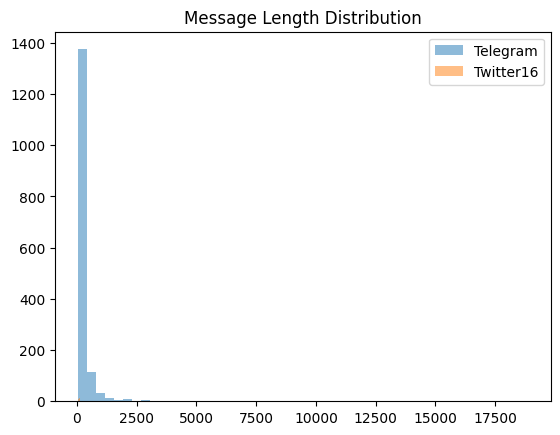

Telegram Length Description: count     1554.000000
mean       263.889961
std        649.739294
min         56.000000
25%        102.000000
50%        155.500000
75%        259.750000
max      18884.000000
Name: length, dtype: float64
Twitter16 Length Description: count    551.000000
mean      90.112523
std       23.986171
min       21.000000
25%       76.000000
50%       92.000000
75%      109.000000
max      140.000000
Name: length, dtype: float64
Telegram TTR: 0.15598338864659173
Twitter16 TTR: 0.3670199951818839
POS Telegram: Counter({'NOUN': 5081, 'PROPN': 4345, 'VERB': 3532, 'ADJ': 1834, 'ADV': 663, 'NUM': 445, 'PRON': 303, 'AUX': 289, 'ADP': 172, 'PART': 135, 'DET': 81, 'INTJ': 73, 'SCONJ': 48, 'CCONJ': 13, 'X': 8, 'PUNCT': 2})
POS Twitter16: Counter({'NOUN': 2456, 'PROPN': 1186, 'PUNCT': 978, 'VERB': 892, 'ADP': 837, 'ADJ': 538, 'DET': 450, 'AUX': 385, 'PRON': 269, 'NUM': 241, 'SYM': 220, 'PART': 203, 'ADV': 186, 'CCONJ': 86, 'SCONJ': 62, 'X': 20, 'INTJ': 17, 'SPACE': 2})


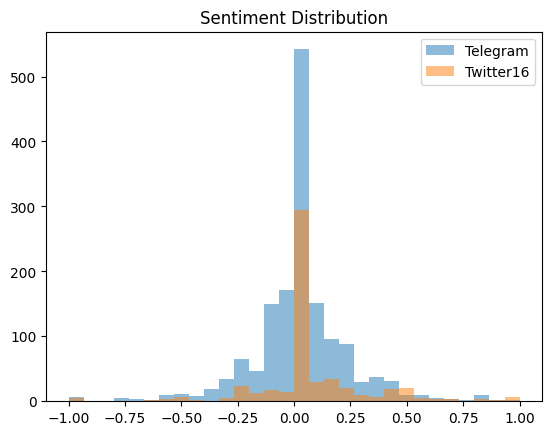

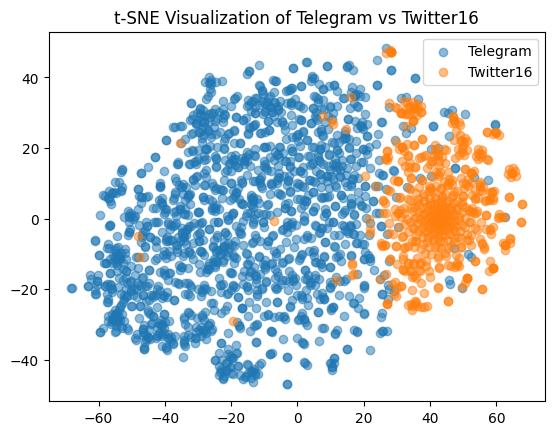

In [75]:
analyze_datasets(df1, df3, text_column_1="Cleaned_text", text_column_3="Text", label1="Telegram", label2="Twitter16", nlp_model="en_core_web_sm")


In [4]:
file_path4 = os.path.join(output_dir2, "ISOT_Fake_News_Dataset.csv")
df4 = pd.read_csv(file_path4)

C:\Users\Hp\AppData\Local\Temp\ipykernel_4300\112290694.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["length"] = df3[text_column_3].apply(lambda x: len(str(x)) if pd.notna(x) else 0)


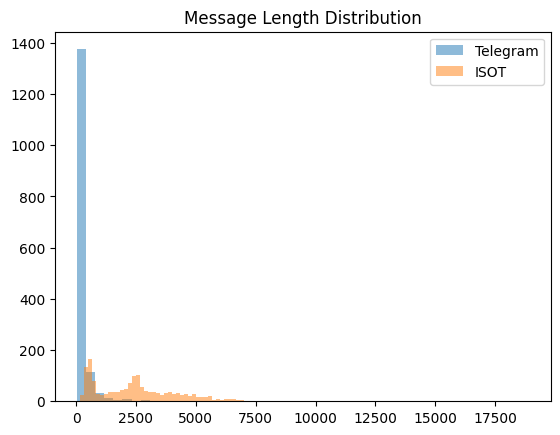

Telegram Length Description: count     1554.000000
mean       263.889961
std        649.739294
min         56.000000
25%        102.000000
50%        155.500000
75%        259.750000
max      18884.000000
Name: length, dtype: float64
ISOT Length Description: count    1554.000000
mean     2458.419562
std      1682.837889
min       168.000000
25%       789.750000
50%      2362.500000
75%      3493.500000
max      8504.000000
Name: length, dtype: float64
Telegram TTR: 0.15598338864659173
ISOT TTR: 0.06489860105494218
POS Telegram: Counter({'NOUN': 5081, 'PROPN': 4345, 'VERB': 3532, 'ADJ': 1834, 'ADV': 663, 'NUM': 445, 'PRON': 303, 'AUX': 289, 'ADP': 172, 'PART': 135, 'DET': 81, 'INTJ': 73, 'SCONJ': 48, 'CCONJ': 13, 'X': 8, 'PUNCT': 2})
POS ISOT: Counter({'NOUN': 40719, 'PROPN': 28558, 'PUNCT': 25300, 'VERB': 24452, 'ADP': 24294, 'DET': 19320, 'ADJ': 13947, 'AUX': 10310, 'PRON': 8740, 'PART': 6869, 'ADV': 5365, 'CCONJ': 5060, 'NUM': 4245, 'SCONJ': 2851, 'SPACE': 1378, 'SYM': 596, 'X': 115,

C:\Users\Hp\AppData\Local\Temp\ipykernel_4300\112290694.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["sentiment"] = df3[text_column_3].apply(get_sentiment)


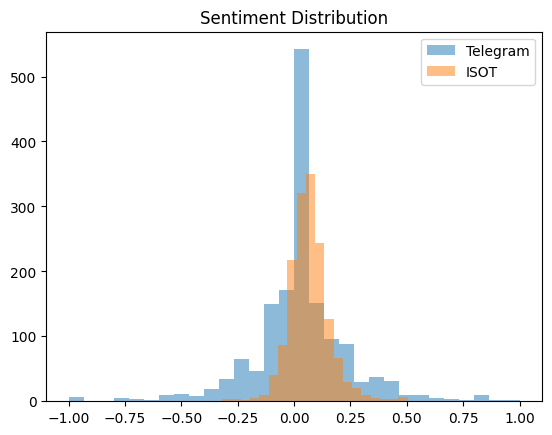

C:\Users\Hp\AppData\Local\Temp\ipykernel_4300\112290694.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[text_column_3] = df3[text_column_3].fillna("")


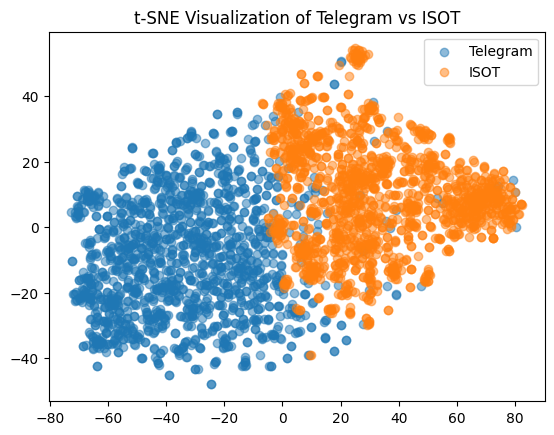

In [8]:
analyze_datasets(df1, df4[:1554], text_column_1="Cleaned_text", text_column_3="Text", label1="Telegram", label2="ISOT", nlp_model="en_core_web_sm")

In [9]:
file_path5 = os.path.join(output_dir2, "FakeNewsNet.csv")
df5 = pd.read_csv(file_path5)

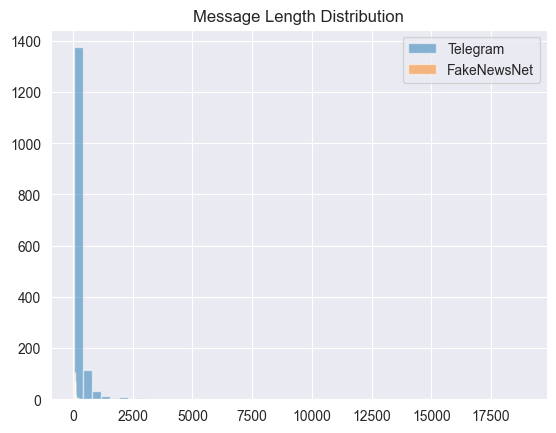

Telegram Length Description: count     1554.000000
mean       263.889961
std        649.739294
min         56.000000
25%        102.000000
50%        155.500000
75%        259.750000
max      18884.000000
Name: length, dtype: float64
FakeNewsNet Length Description: count    1056.000000
mean       59.889205
std        31.335519
min        10.000000
25%        38.000000
50%        59.000000
75%        78.000000
max       340.000000
Name: length, dtype: float64
Telegram TTR: 0.15598338864659173
FakeNewsNet TTR: 0.4524190323870452
POS Telegram: Counter({'NOUN': 5081, 'PROPN': 4345, 'VERB': 3532, 'ADJ': 1834, 'ADV': 663, 'NUM': 445, 'PRON': 303, 'AUX': 289, 'ADP': 172, 'PART': 135, 'DET': 81, 'INTJ': 73, 'SCONJ': 48, 'CCONJ': 13, 'X': 8, 'PUNCT': 2})
POS FakeNewsNet: Counter({'PROPN': 2290, 'NOUN': 737, 'PUNCT': 697, 'ADP': 665, 'VERB': 612, 'AUX': 219, 'DET': 215, 'ADJ': 209, 'PRON': 209, 'PART': 162, 'NUM': 158, 'ADV': 120, 'CCONJ': 63, 'SCONJ': 50, 'SYM': 18, 'SPACE': 9, 'X': 8, 'INTJ': 

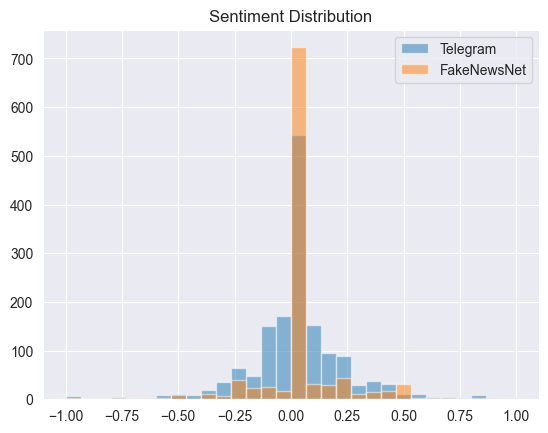

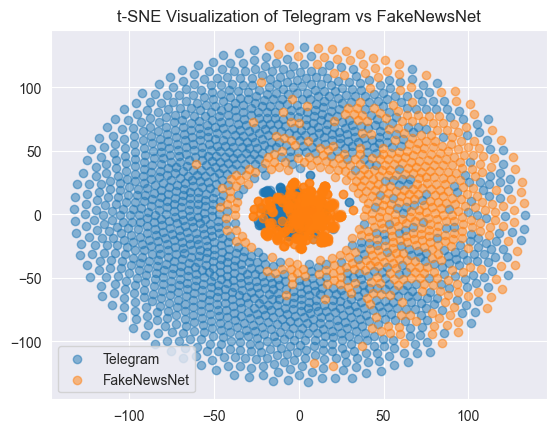

In [10]:
analyze_datasets(df1, df5, text_column_1="Cleaned_text", text_column_3="Text", label1="Telegram", label2="FakeNewsNet", nlp_model="en_core_web_sm")

In [12]:
df1.drop(columns=["length", "sentiment"], inplace=True)

In [13]:
file_path3 = os.path.join(output_dir1, "fake_news_flag_01.xlsx")
df1.to_excel(file_path3, index=False)

In [5]:
df4["length"] = df4["Text"].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

In [14]:
df4["length"].describe()

count    45003.000000
mean      2459.137013
std       2097.650150
min          0.000000
25%       1226.000000
50%       2183.000000
75%       3101.000000
max      32759.000000
Name: length, dtype: float64

In [15]:
df4.head()

,Text,Fake_News_Flag,length
0,WASHINGTON (Reuters) - The head of a conservat...,True,4659
1,WASHINGTON (Reuters) - Transgender people will...,True,4077
2,WASHINGTON (Reuters) - The special counsel inv...,True,2789
3,WASHINGTON (Reuters) - Trump campaign adviser ...,True,2461
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,True,5204


In [6]:
new_df = df4[(df4["length"] >= 56) & (df4["length"] <= 3297)]

In [7]:
new_df["Fake_News_Flag"].value_counts()

Fake_News_Flag
False    17931
True     16237
Name: count, dtype: int64

In [18]:
new_df = new_df.drop_duplicates()

In [19]:
# Select 1000 rows from each category
false_subset_1000 = new_df[new_df["Fake_News_Flag"] == False].sample(n=2750, random_state=42)
true_subset_1000 = new_df[new_df["Fake_News_Flag"] == True].sample(n=2750, random_state=42)

subset_df_1000 = pd.concat([false_subset_1000, true_subset_1000])

In [20]:
subset_df_1000["Fake_News_Flag"].value_counts()

Fake_News_Flag
False    2750
True     2750
Name: count, dtype: int64

In [21]:
file_path4 = os.path.join(output_dir2, "ISOT_Fake_News_subset.csv")
subset_df_1000.to_csv(file_path4, index=False)